# Simple RNN for time series generation

In [2]:
# Imports
# Network based on https://www.geeksforgeeks.org/time-series-forecasting-using-recurrent-neural-networks-rnn-in-tensorflow/
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math


In [59]:
# Import finance data
#the start and end date
# start_date = dt.datetime(2020,4,1)
# end_date = dt.datetime(2023,4,1)

# #loading from yahoo finance
# data = yf.download("GOOGL",start_date, end_date) #Downloaded as a DataFrame

# pd.set_option('display.max_rows', 4)
# pd.set_option('display.max_columns',5)
# print(data)
data = np.loadtxt(f'sine_data/sine_123_1000_1.csv', delimiter = ",",skiprows = 1)
# data = data[0]
data = pd.DataFrame(data)
data = data[1]


In [60]:
# Splitting data into train and test
# Setting 80 percent data for training
training_data_len = math.ceil(len(data) * .8)

#Splitting the dataset
train_data = data[:training_data_len] #Only using the open feature
test_data = data[training_data_len:]
print(train_data.shape, test_data.shape)

(800,) (200,)


In [66]:
#Preprocessing

# Selecting Open Price values
# dataset_train = train_data.Open.values #Turns it into a numpy array
# dataset_test = test_data.Open.values 
# Reshaping 1D to 2D array
dataset_train = np.reshape(train_data, (-1,1)) 
dataset_test = np.reshape(test_data, (-1,1))

from sklearn.preprocessing import MinMaxScaler
# Normalizing values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test) 

# print(scaled_train[:5])
# print(*scaled_test[:5])


In [67]:
X_train = []
y_train = []
for i in range(50, len(scaled_train)):
	X_train.append(scaled_train[i-50:i, 0])
	y_train.append(scaled_train[i, 0])
	if i <= 51:
		pass
		# print(X_train)
		# print(y_train)
		# print()
print(len(X_train), len(X_train[0]))
print(X_train[1])
print(y_train[0]) #y_train[i] is the next value after the 50 values in X_train[i]

750 50
[6.40619989e-01 7.66161496e-01 8.71534845e-01 9.48753498e-01
 9.91964837e-01 9.97893757e-01 9.66090887e-01 8.98966655e-01
 8.01608594e-01 6.81395740e-01 5.47439361e-01 4.09892381e-01
 2.79179869e-01 1.65208889e-01 7.66176177e-02 2.01206336e-02
 0.00000000e+00 1.77807157e-02 7.21151308e-02 1.58885089e-01
 2.71514055e-01 4.01465565e-01 5.38890235e-01 6.73372267e-01
 7.94718894e-01 8.93732919e-01 9.62909793e-01 9.97006410e-01
 9.93438491e-01 9.52476460e-01 8.77224943e-01 7.73387460e-01
 6.48834144e-01 5.13005235e-01 3.76195584e-01 2.48774375e-01
 1.40399214e-01 5.92841565e-02 1.15771371e-02 8.94003634e-04
 2.80444604e-02 9.09706989e-02 1.84903365e-01 3.02723040e-01
 4.35499846e-01 5.73170257e-01 7.05299853e-01 8.21874164e-01
 9.14057698e-01 9.74863611e-01]
0.9748636114271005


In [68]:
X_test = []
y_test = []
for i in range(50, len(scaled_test)):
    X_test.append(scaled_test[i-50:i, 0])
    y_test.append(scaled_test[i, 0])

In [69]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

print(X_train[1])

X_train : (750, 50, 1) y_train : (750, 1)
X_test : (150, 50, 1) y_test : (150, 1)
[[6.40619989e-01]
 [7.66161496e-01]
 [8.71534845e-01]
 [9.48753498e-01]
 [9.91964837e-01]
 [9.97893757e-01]
 [9.66090887e-01]
 [8.98966655e-01]
 [8.01608594e-01]
 [6.81395740e-01]
 [5.47439361e-01]
 [4.09892381e-01]
 [2.79179869e-01]
 [1.65208889e-01]
 [7.66176177e-02]
 [2.01206336e-02]
 [0.00000000e+00]
 [1.77807157e-02]
 [7.21151308e-02]
 [1.58885089e-01]
 [2.71514055e-01]
 [4.01465565e-01]
 [5.38890235e-01]
 [6.73372267e-01]
 [7.94718894e-01]
 [8.93732919e-01]
 [9.62909793e-01]
 [9.97006410e-01]
 [9.93438491e-01]
 [9.52476460e-01]
 [8.77224943e-01]
 [7.73387460e-01]
 [6.48834144e-01]
 [5.13005235e-01]
 [3.76195584e-01]
 [2.48774375e-01]
 [1.40399214e-01]
 [5.92841565e-02]
 [1.15771371e-02]
 [8.94003634e-04]
 [2.80444604e-02]
 [9.09706989e-02]
 [1.84903365e-01]
 [3.02723040e-01]
 [4.35499846e-01]
 [5.73170257e-01]
 [7.05299853e-01]
 [8.21874164e-01]
 [9.14057698e-01]
 [9.74863611e-01]]


### Define basic RNN

In [70]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error


In [71]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50, 
						activation = "tanh",
						return_sequences = True,
						input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50, 
						activation = "tanh",
						return_sequences = True))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
								decay=1e-6, 
								momentum=0.9, 
								nesterov=True), 
				loss = "mean_squared_error")

# fitting the model
regressor.fit(X_train, y_train, epochs = 20, batch_size = 2)
regressor.summary()


Epoch 1/20
375/375 [==============================] - 89s 212ms/step - loss: 0.0060
Epoch 2/20
375/375 [==============================] - 82s 219ms/step - loss: 8.4978e-04
Epoch 3/20
375/375 [==============================] - 87s 232ms/step - loss: 6.0417e-04
Epoch 4/20
375/375 [==============================] - 73s 195ms/step - loss: 5.0478e-04
Epoch 5/20
375/375 [==============================] - 103s 275ms/step - loss: 3.4641e-04
Epoch 6/20
375/375 [==============================] - 61s 162ms/step - loss: 3.4892e-04
Epoch 7/20
375/375 [==============================] - 80s 212ms/step - loss: 2.9271e-04
Epoch 8/20
375/375 [==============================] - 45s 121ms/step - loss: 2.9596e-04
Epoch 9/20
375/375 [==============================] - 44s 118ms/step - loss: 2.7810e-04
Epoch 10/20
375/375 [==============================] - 72s 192ms/step - loss: 2.1868e-04
Epoch 11/20
375/375 [==============================] - 59s 158ms/step - loss: 2.3719e-04
Epoch 12/20
375/375 [============

In [72]:
y_RNN = regressor.predict(X_test)

# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN)

5/5 [==============================] - 3s 107ms/step


In [73]:
print(len(y_RNN_O))

150


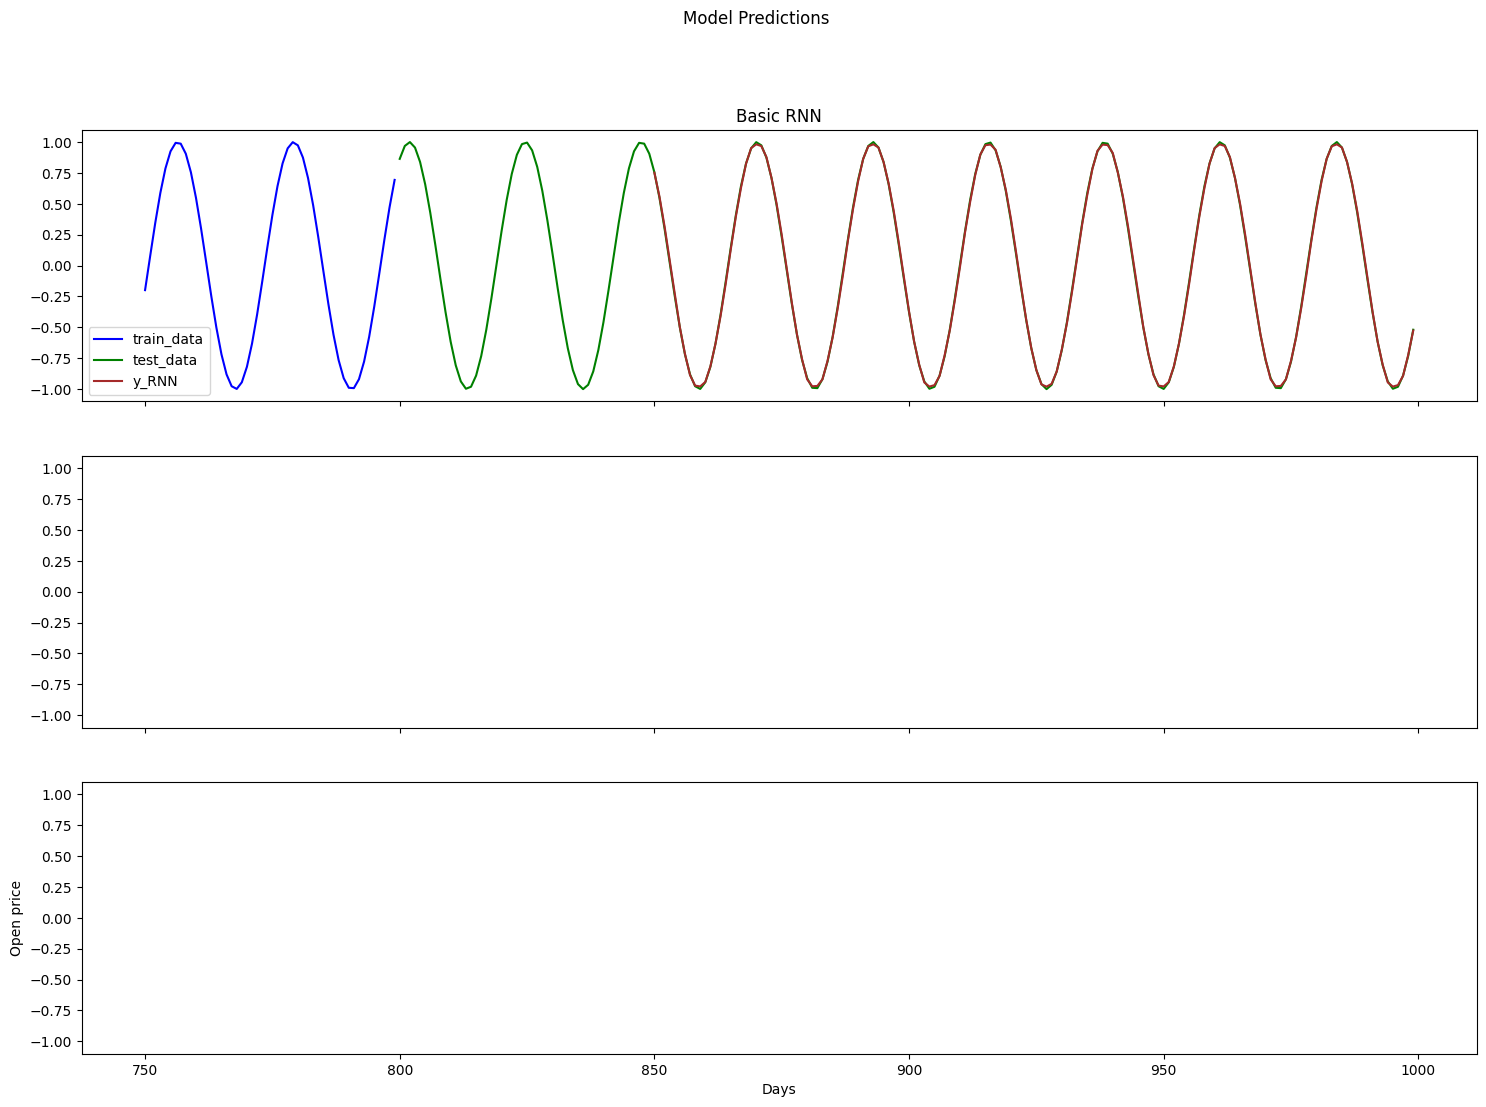

In [78]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')
 
#Plot for RNN predictions
axs[0].plot(train_data.index[750:], train_data[750:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

plt.xlabel("Days")
plt.ylabel("Open price")
 
plt.show()